In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!pip install facenet-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 12.5 MB/s eta 0:00:00


In [3]:
%cd ./DL_project

/content/yoloface


In [4]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 63.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 64.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 MB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 45.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 90.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.8/39.8 MB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.8/292.8 kB 38.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 80.2 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement torch==1.12.1+cu116 (from versions: 1.7.1, 1.8.0, 1.8.1, 1.9.0, 1.9.1, 1.10.0, 1.10.1, 1.10.2, 1.11.0, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 2.0.0)
ERROR: No matching distribution found for torch==1.1

In [5]:
!pip install thop

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
from face_detector import YoloDetector

In [7]:
from facenet_pytorch import MTCNN, InceptionResnetV1
from face_detector import YoloDetector
import torch 
import numpy as np

In [8]:
import os
import glob
import cv2
from google.colab.patches import cv2_imshow

Load model

In [ ]:
help(YoloDetector)

In [40]:
help(InceptionResnetV1)

Help on class InceptionResnetV1 in module facenet_pytorch.models.inception_resnet_v1:

class InceptionResnetV1(torch.nn.modules.module.Module)
 |  InceptionResnetV1(pretrained=None, classify=False, num_classes=None, dropout_prob=0.6, device=None)
 |  
 |  Inception Resnet V1 model with optional loading of pretrained weights.
 |  
 |  Model parameters can be loaded based on pretraining on the VGGFace2 or CASIA-Webface
 |  datasets. Pretrained state_dicts are automatically downloaded on model instantiation if
 |  requested and cached in the torch cache. Subsequent instantiations use the cache rather than
 |  redownloading.
 |  
 |  Keyword Arguments:
 |      pretrained {str} -- Optional pretraining dataset. Either 'vggface2' or 'casia-webface'.
 |          (default: {None})
 |      classify {bool} -- Whether the model should output classification probabilities or feature
 |          embeddings. (default: {False})
 |      num_classes {int} -- Number of output classes. If 'pretrained' is s

In [12]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


**Define methods**

In [13]:
resnet = InceptionResnetV1(pretrained='vggface2', device=device).eval()

  0%|          | 0.00/107M [00:00<?, ?B/s]

In [14]:
model = YoloDetector(target_size = 720, device = "cuda:0",min_face = 20)

cuda:0
/content/yoloface/weights/yolov5n_state_dict.pt


In [20]:
mtcnn = MTCNN(image_size=160, margin=0, min_face_size=20,
              thresholds=[0.6, 0.6, 0.6], factor=0.709, post_process=True,
              select_largest=False, selection_method=None, keep_all=True, 
              device=device
              )

utility methods

In [104]:
def detection(img, show=False):
  bboxes, points = model.predict(img)
  # crop and align image
  faces = model.align(img, points[0])
  # show pictures
  if show == True:
    for face in faces:
      cv2_imshow(face)  
  # Reshape tensor for resnet module
  faces = torch.tensor(faces)
  faces = faces.permute(0, 3, 1, 2)
  faces = faces.float()
  #bboxes = [float(num) for num in bboxes]
  return faces, bboxes

In [105]:
def get_embeddings(faces):
    faces = faces.to(device)
    unknown_embeddings = resnet(faces).detach().cpu()
    return unknown_embeddings

In [118]:
def recognition(face_db, unknown_embeddings, recog_thr) : 
    face_ids = []
    probs = []
    for i in range(len(unknown_embeddings)):
        result_dict = {}
        eb = unknown_embeddings[i]
        for name in face_db.keys():
            knownfeature_list = face_db[name]
            prob_list = []
            for knownfeature in knownfeature_list:
                prob = (eb - knownfeature).norm().item()
                prob_list.append(prob)
                if prob > recog_thr:
                    # 기준 넘으면 바로 break해서 같은 인물 계속 안 체크하도록
                    break
            result_dict[name] = min(prob_list)
        results = sorted(result_dict.items(), key=lambda d:d[1])
        result_name, result_probs = results[0][0], results[0][1]
        if result_probs > recog_thr: 
            face_ids.append(result_name)
        else : 
            face_ids.append('unknown')
        probs.append(result_probs)
    return face_ids, probs

In [127]:
def process_image_(img_list, target, recog_thr=0.6):
  faces = []
  bboxes = []
  for img in img_list:
    face, bbox = detection(img)
    faces.append(face)
    bboxes.append(bbox)
  
  faces = torch.cat(faces, dim=0)

  unknown_embeddings = get_embeddings(faces)
  face_ids, probs = recognition(target, unknown_embeddings, recog_thr)

  return face_ids, probs

    

In [131]:
def preprocess(img, target, recog_thr=0.6) :
  faces, bboxes = detection(img)

  unknown_embeddings = get_embeddings(faces)
  face_ids, probs = recognition(target, unknown_embeddings, recog_thr)

  return face_ids, probs


In [141]:
def process_image(img_list, target, recog_thr=0.6): 
  results=[]

  for img in img_list:
    _, bboxes = detection(img)
    face_ids, _ = preprocess(img, target)
    result = DrawRectImg(img, bboxes, face_ids)
    results.append(result)

  return results

In [138]:
def DrawRectImg(img, bboxes, face_ids):
    rect_color = (0, 0, 255) # BGR
    rect_color_ = (225, 0, 0)
    rect_thickness = 2 # 이미지 사이즈에 맞게 조절해야할지도
    font_scale = 1 # 위와 동일
    font_color = (0, 0, 255) # BGR
    font_color_ = (255, 0, 0)
    font_thickness = 1 # 위와 동일
    
    for (bbox, face_id) in zip(bboxes[0], face_ids):
        if face_id != 'unknown':
            # bbox: x0, y0, x1, y1
            bbox = np.round(bbox).astype(int)
            cv2.rectangle(img, (bbox[0], bbox[1]), (bbox[2], bbox[3]),
                            rect_color, rect_thickness)
            cv2.putText(img, face_id, (bbox[0], bbox[1]-5),
                            1, font_scale, font_color, font_thickness)
            
        if face_id == 'unknown':
            # bbox: x0, y0, x1, y1
            bbox = np.round(bbox).astype(int)
            cv2.rectangle(img, (bbox[0], bbox[1]), (bbox[2], bbox[3]),
                            rect_color_, rect_thickness)
            cv2.putText(img, face_id, (bbox[0], bbox[1]-5),
                            1, font_scale, font_color_, font_thickness)
    img_draw = img

    return img_draw

**Test**

for target

In [17]:
# select the path
target_path = "/content/drive/MyDrive/칠칠맞조/DL_project/target_image/*.*"
target_images = []
for file in glob.glob(target_path):
  image_read = cv2.imread(file)
  # conversion numpy array into rgb image to show
  target_images.append(image_read)
  # # wait for 1 second
  # k = cv2.waitKey(1000)
  # # destroy the window
  # cv2.destroyAllWindows()
  

In [ ]:
target_images

In [ ]:
for img in target_images:
  cv2_imshow(img)

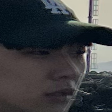

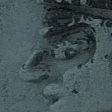

<ipython-input-53-dfeba3e819e5>:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  faces = torch.tensor(faces)


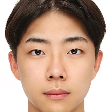

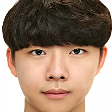

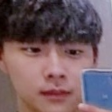

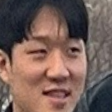

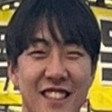

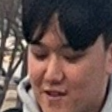

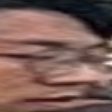

In [59]:
target_list = []

for img in target_images:
  detection(img, True)



In [77]:
target_list = []
target_list.append(detection(target_images[0])[0])
target_list.append(detection(target_images[1])[0])
target_list.append(detection(target_images[2])[0])
target_list.append(detection(target_images[3])[0])
target_list.append(detection(target_images[4])[1])



In [78]:
target_list = torch.stack(target_list, dim=0)

In [79]:
target_list.shape

torch.Size([5, 3, 112, 112])

In [83]:
target_vectors = get_embeddings(target_list)

In [84]:
target_vectors

tensor([[ 0.02702, -0.03600,  0.01950,  ...,  0.01334, -0.00323, -0.03708],
        [ 0.07037, -0.04325,  0.03483,  ...,  0.02603,  0.02365, -0.01028],
        [ 0.02763, -0.01742,  0.01423,  ..., -0.02758, -0.03420, -0.00950],
        [ 0.01979, -0.00394,  0.04036,  ...,  0.00930, -0.01283, -0.02283],
        [ 0.04803, -0.02605,  0.04334,  ...,  0.02902,  0.00665, -0.03680]])

In [85]:
face_db = {}
face_db['charm_zu'] = target_vectors

In [86]:
face_db

{'charm_zu': tensor([[ 0.02702, -0.03600,  0.01950,  ...,  0.01334, -0.00323, -0.03708],
         [ 0.07037, -0.04325,  0.03483,  ...,  0.02603,  0.02365, -0.01028],
         [ 0.02763, -0.01742,  0.01423,  ..., -0.02758, -0.03420, -0.00950],
         [ 0.01979, -0.00394,  0.04036,  ...,  0.00930, -0.01283, -0.02283],
         [ 0.04803, -0.02605,  0.04334,  ...,  0.02902,  0.00665, -0.03680]])}

In [87]:
# save face_db

import pickle

with open("face_db.pickle", "wb") as fw:
  pickle.dump(face_db, fw)

Test

In [88]:
# load face_db

with open("face_db.pickle", "rb") as fr:
  data = pickle.load(fr)

print(data)

{'charm_zu': tensor([[ 0.02702, -0.03600,  0.01950,  ...,  0.01334, -0.00323, -0.03708],
        [ 0.07037, -0.04325,  0.03483,  ...,  0.02603,  0.02365, -0.01028],
        [ 0.02763, -0.01742,  0.01423,  ..., -0.02758, -0.03420, -0.00950],
        [ 0.01979, -0.00394,  0.04036,  ...,  0.00930, -0.01283, -0.02283],
        [ 0.04803, -0.02605,  0.04334,  ...,  0.02902,  0.00665, -0.03680]])}


In [89]:
# select the path
test_path = "/content/drive/MyDrive/칠칠맞조/DL_project/test_image/*.*"
test_images = []
for file in glob.glob(test_path):
  image_read = cv2.imread(file)
  # conversion numpy array into rgb image to show
  test_images.append(image_read)
  # # wait for 1 second
  # k = cv2.waitKey(1000)
  # # destroy the window
  # cv2.destroyAllWindows()
  

In [ ]:
test_images

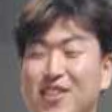

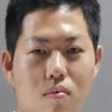

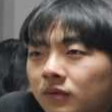

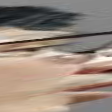

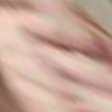

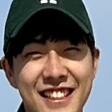

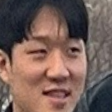

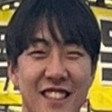

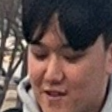

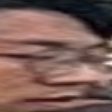

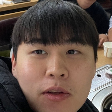

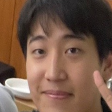

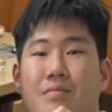

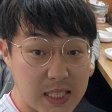

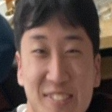

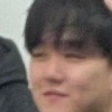

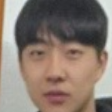

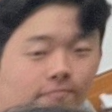

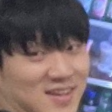

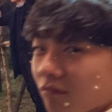

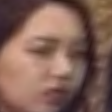

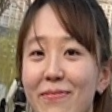

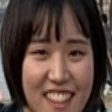

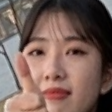

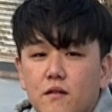

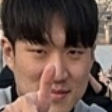

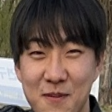

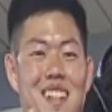

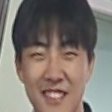

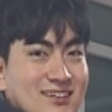

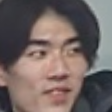

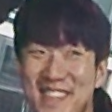

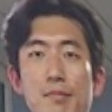

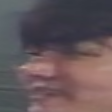

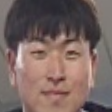

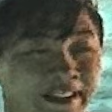

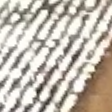

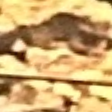

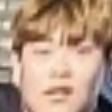

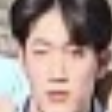

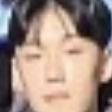

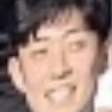

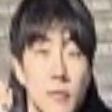

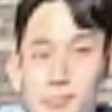

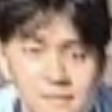

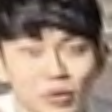

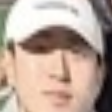

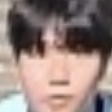

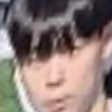

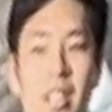

In [99]:
test_list = []

for img in test_images:
  detection(img, True)

In [140]:
preprocess(test_images[0],data)

(['unknown', 'charm_zu', 'unknown', 'unknown', 'unknown'],
 [0.5432755947113037,
  0.6498600840568542,
  0.37368160486221313,
  0.50020432472229,
  0.5919503569602966])

In [142]:
results = process_image(test_images, data)

In [ ]:
for img in results:
  cv2_imshow(img)

In [117]:
probs

[0.6319469809532166,
 0.5653514862060547,
 0.4933798611164093,
 0.5002043843269348,
 0.5919504165649414,
 0.4642885625362396,
 0.5131719708442688,
 0.4146157503128052,
 0.6172003746032715,
 0.504447877407074,
 0.4006839990615845,
 0.4614676237106323,
 0.5259183645248413,
 0.40748295187950134,
 0.4959836006164551,
 0.48861971497535706,
 0.42672085762023926,
 0.5876634120941162,
 0.4777102768421173,
 0.5525876879692078,
 0.4650530517101288,
 0.4753258228302002,
 0.601715624332428,
 0.5406202673912048,
 0.54168301820755,
 0.5406351089477539,
 0.5375475287437439,
 0.5720940232276917,
 0.43229395151138306,
 0.5452602505683899,
 0.5577526092529297,
 0.40086686611175537,
 0.5382512211799622,
 0.5589277744293213,
 0.45733630657196045,
 0.48755964636802673,
 0.7046039700508118,
 0.43622922897338867,
 0.49952903389930725,
 0.47205886244773865,
 0.46035894751548767,
 0.5042851567268372,
 0.447713166475296,
 0.5235055685043335,
 0.5045832991600037,
 0.4938095211982727,
 0.4630584716796875,
 0.6489